# Recurrent Neural Networks and The Yield Curve 

Objectives:
- Learning Multistep, multifeature time series modelling
- Naive Bayesian to a more complicated Advanced RNN (LSTM) 
- Any guesses on which will perform better?

Today we will be exploring yield curves spreads and using data from **Quandl**. Quandl offers quick and easy API's to use and retrieve for free, and already in DataFrame form. Who says a free lunch doesn't exist!


- Here is the data: https://www.quandl.com/data/USTREASURY/YIELD-Treasury-Yield-Curve-Rates
- Here is a tutorial to install Quandl: https://www.quandl.com/tools/python

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, TimeDistributed
from keras.losses import MAE
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import statsmodels.api as sm
import pandas as pd

Using TensorFlow backend.


In [2]:
import quandl
df = quandl.get("USTREASURY/YIELD", authtoken="s-LF8xGE9kdc-bsVjrUN")

In [3]:
df.head(5)

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09


In [4]:
# This is method is equivalent to washing your hands in Covid-19... ALWAYS AND OFTEN!
df.describe()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
count,4788.000000,483.000000,7684.000000,7687.000000,7687.000000,7687.000000,7687.000000,7687.000000,7687.000000,7687.000000,6748.000000,6693.000000
mean,1.265430,1.515921,2.724485,2.853921,2.979031,3.277357,3.492496,3.884289,4.189014,4.424992,4.520616,4.962931
std,1.471021,0.931893,2.286465,2.321203,2.321061,2.343571,2.293965,2.180802,2.090914,1.983019,1.666337,1.916208
min,0.000000,0.000000,0.000000,0.020000,0.080000,0.110000,0.100000,0.190000,0.360000,0.520000,0.870000,0.990000
25%,0.070000,0.150000,0.240000,0.410000,0.550000,0.940000,1.370000,1.820000,2.240000,2.650000,2.910000,3.110000
50%,0.880000,1.750000,2.340000,2.460000,2.560000,2.950000,3.250000,3.770000,4.050000,4.320000,4.660000,4.780000
75%,1.910000,2.365000,4.990000,5.100000,5.100000,5.370000,5.510000,5.730000,5.940000,5.950000,5.830000,6.490000
max,5.270000,2.480000,8.260000,8.490000,8.640000,9.050000,9.110000,9.100000,9.120000,9.090000,8.300000,9.180000


We are going to drop a couple features (Maturities). In specfic: the 1 month, the 2 month and 30 year. The 1 month was created in '01, the 30 year was removed in '01 and brought back in. Anyhow, sparse data makes things a little more confusing for time series modelling so we are going to remove them. 

In [5]:
df = df.drop(['1 MO','2 MO','30 YR'], axis = 1)
df = df.dropna(axis = 0)

In [6]:
df

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993-10-01,2.98,3.11,3.35,3.84,4.18,4.72,5.03,5.34,6.12
1993-10-04,3.02,3.17,3.35,3.85,4.16,4.71,5.04,5.34,6.10
1993-10-05,3.06,3.20,3.38,3.86,4.18,4.72,5.05,5.35,6.12
1993-10-06,3.04,3.19,3.36,3.85,4.16,4.70,5.05,5.35,6.12
1993-10-07,3.05,3.17,3.35,3.83,4.15,4.69,5.05,5.33,6.11
...,...,...,...,...,...,...,...,...,...
2020-09-15,0.11,0.12,0.13,0.14,0.16,0.27,0.46,0.68,1.21
2020-09-16,0.12,0.12,0.12,0.14,0.16,0.28,0.47,0.69,1.23
2020-09-17,0.09,0.11,0.12,0.13,0.16,0.28,0.47,0.69,1.22


In [7]:
df.index.year

Int64Index([1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='Date', length=6745)

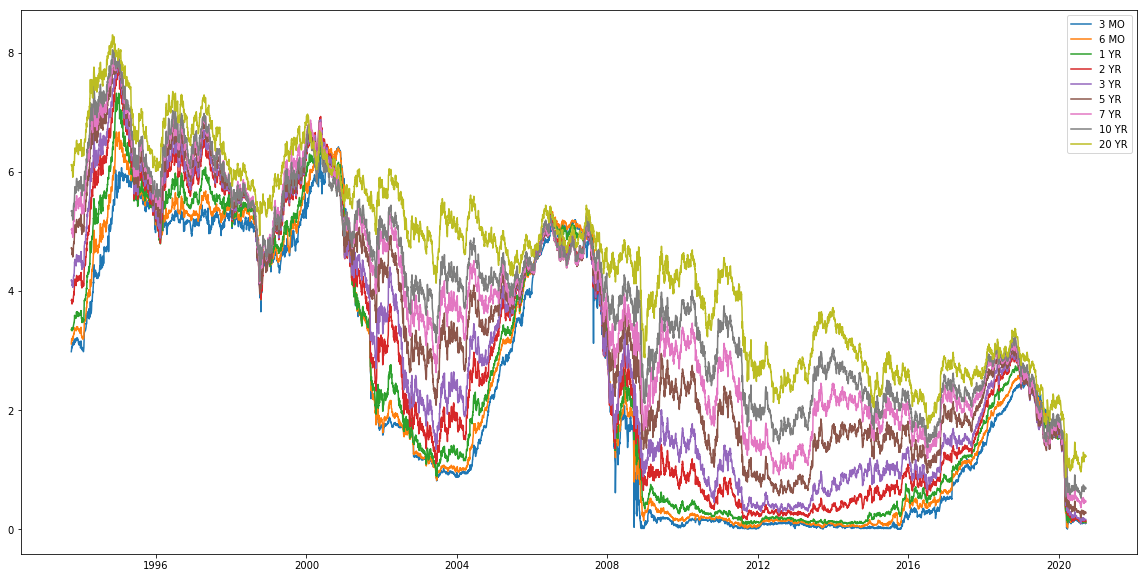

In [8]:
plt.figure(figsize=(20,10));
plt.plot(df);
plt.legend(df);

Separate it a bit more

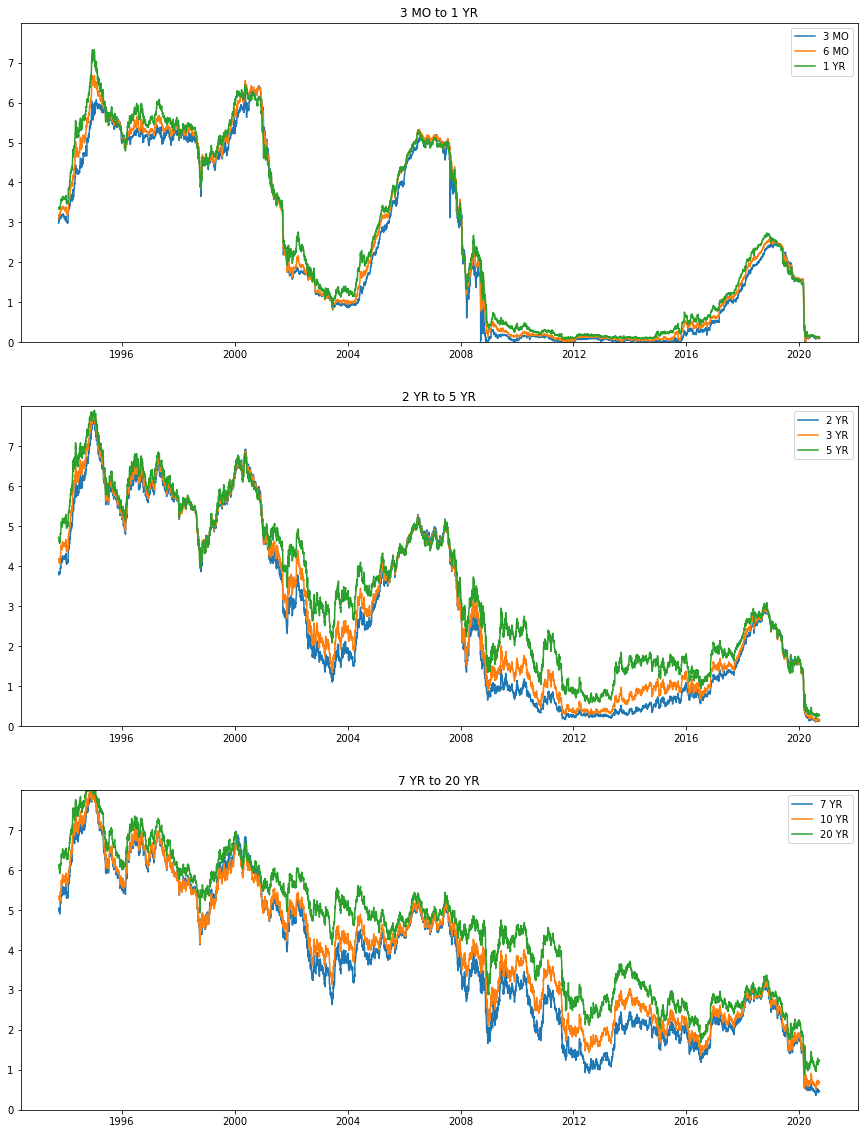

In [9]:
f, axes = plt.subplots(3, 1, figsize=(15, 20))

j = 0
while j < 3:
    for i in range(0,len(df.columns),3):
        new = df.iloc[:,i:i+3]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{new.columns[0]} to {new.columns[-1]}")
        axes[j].plot(new, label = new.columns)
        axes[j].legend(new)
    
        j += 1

### Yearly Yield curve plots
- Lets plot the yield curve over an annual basis. 
- 2 Steps:
1. Groupby year and take the mean value
2. Transpose the dataset

In [10]:
dfyear = df.groupby(df.index.year).mean()
dfystd = df.groupby(df.index.year).std()

In [11]:
dfyear

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993,3.132903,3.306290,3.528710,4.085000,4.408710,4.977903,5.333387,5.615968,6.285968
1994,4.372490,4.826506,5.317470,5.942972,6.270442,6.688273,6.907711,7.085181,7.490080
1995,5.660360,5.817560,5.942120,6.151440,6.254720,6.383320,6.496440,6.573920,6.954640
1996,5.145595,5.290635,5.515913,5.844960,5.994802,6.182103,6.343770,6.443532,6.826111
1997,5.201440,5.390160,5.631520,5.990880,6.102960,6.224680,6.326920,6.353960,6.686840
1998,4.906960,5.020160,5.052520,5.130520,5.137920,5.152320,5.278640,5.262880,5.715960
1999,4.777211,4.945817,5.083108,5.434303,5.492948,5.550040,5.786255,5.646135,6.197809
2000,5.999920,6.173984,6.112948,6.260916,6.220598,6.157769,6.200518,6.030279,6.230916
2001,3.478669,3.453065,3.490000,3.830887,4.089274,4.556694,4.881653,5.020685,5.632177


In [12]:
dfyear.head(5)
dfpct = dfyear.pct_change()
dfpct.dropna(axis = 0)

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1994,0.395667,0.459795,0.506916,0.454828,0.422285,0.343592,0.295183,0.261614,0.191556
1995,0.294539,0.205336,0.117471,0.035078,-0.002507,-0.045595,-0.059538,-0.072159,-0.071487
1996,-0.090942,-0.090575,-0.071726,-0.049822,-0.041556,-0.031522,-0.023501,-0.019834,-0.018481
1997,0.010853,0.018812,0.020959,0.024965,0.018042,0.006887,-0.002656,-0.013901,-0.020403
1998,-0.056615,-0.068644,-0.102814,-0.143612,-0.158127,-0.172276,-0.165686,-0.171717,-0.145193
1999,-0.026442,-0.014809,0.006054,0.059211,0.069100,0.077192,0.096164,0.072822,0.084299
2000,0.255946,0.248324,0.202601,0.152110,0.132470,0.109500,0.071594,0.068037,0.005342
2001,-0.420214,-0.440707,-0.429081,-0.388127,-0.342624,-0.260009,-0.212702,-0.167421,-0.096092
2002,-0.529901,-0.502911,-0.426395,-0.311449,-0.241939,-0.162612,-0.118209,-0.081185,-0.035613


In [13]:
dfpct.index[-1:]

Int64Index([2020], dtype='int64', name='Date')

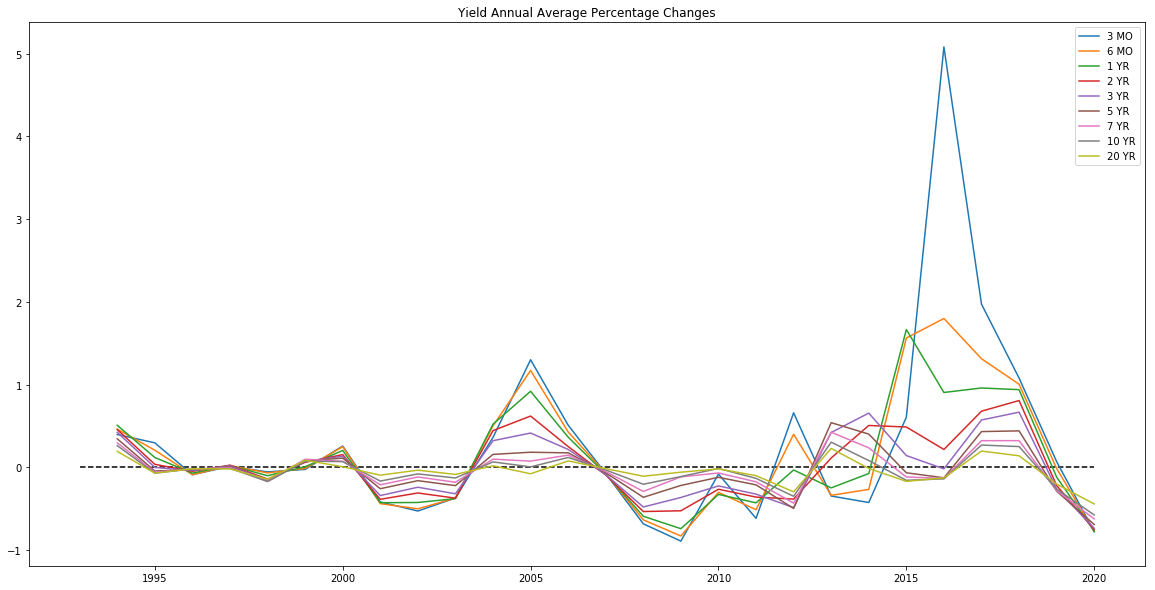

In [14]:
plt.figure(figsize=(20,10));
plt.hlines(y=0, xmin = dfpct.index[0], xmax = dfpct.index[-1:], colors='black', linestyles='--', data = dfpct)
plt.plot(dfpct);
plt.legend(df);
plt.title("Yield Annual Average Percentage Changes");

This jump in 2015 may look noteworthy but be weary, the 3 month yield was near bottomed-out (Known as The Zero Lower Bound). A 508% increase only lifted rates approximately 25 basis points. 

In [15]:
dfystd.head(5) #Volatility

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993,0.050777,0.070181,0.101731,0.155213,0.172165,0.202072,0.209041,0.210421,0.167826
1994,0.798743,0.927014,1.008228,0.978855,0.930071,0.806113,0.725545,0.665725,0.549137
1995,0.221006,0.351246,0.525907,0.656932,0.680560,0.681138,0.653812,0.630063,0.568746
1996,0.101766,0.158970,0.283406,0.412689,0.440883,0.442621,0.419016,0.403634,0.354751
1997,0.102555,0.112860,0.175028,0.234276,0.271121,0.305811,0.312417,0.337215,0.343594


In [16]:
yieldcurvestd = dfystd.T 
yieldcurvestd

Date,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3 MO,0.050777,0.798743,0.221006,0.101766,0.102555,0.359078,0.297304,0.265588,1.116287,0.189192,...,0.047916,0.021913,0.025426,0.013848,0.065651,0.085153,0.244715,0.294299,0.336178,0.592330
6 MO,0.070181,0.927014,0.351246,0.158970,0.112860,0.373829,0.366975,0.201352,1.065265,0.239987,...,0.050353,0.024124,0.023533,0.019636,0.129732,0.079997,0.249673,0.278445,0.357119,0.577933
1 YR,0.101731,1.008228,0.525907,0.283406,0.175028,0.443142,0.385703,0.187331,0.887453,0.376551,...,0.069172,0.023732,0.017165,0.034308,0.130983,0.108397,0.252874,0.279459,0.386050,0.545703
2 YR,0.155213,0.978855,0.656932,0.412689,0.234276,0.514566,0.445856,0.387246,0.699559,0.636042,...,0.208644,0.035563,0.059177,0.091342,0.132113,0.150979,0.192446,0.259540,0.385958,0.521592
3 YR,0.172165,0.930071,0.680560,0.440883,0.271121,0.507353,0.461298,0.416417,0.571981,0.723426,...,0.350387,0.059765,0.157305,0.117959,0.128306,0.204619,0.157294,0.231089,0.386051,0.503556
5 YR,0.202072,0.806113,0.681138,0.442621,0.305811,0.526838,0.482092,0.442287,0.379573,0.700338,...,0.527494,0.126960,0.341822,0.091374,0.138051,0.256950,0.131895,0.174009,0.390135,0.472687
7 YR,0.209041,0.725545,0.653812,0.419016,0.312417,0.466201,0.506381,0.424276,0.326441,0.618093,...,0.594196,0.186113,0.421110,0.121477,0.156872,0.277623,0.117261,0.159978,0.390477,0.440218
10 YR,0.210421,0.665725,0.630063,0.403634,0.337215,0.424912,0.475559,0.391931,0.285667,0.536607,...,0.626627,0.205378,0.413890,0.198238,0.166284,0.283955,0.108628,0.155953,0.402192,0.410081
20 YR,0.167826,0.549137,0.568746,0.354751,0.343594,0.275368,0.394280,0.315021,0.213432,0.380278,...,0.671842,0.228110,0.387958,0.282485,0.202224,0.288214,0.105597,0.151695,0.364554,0.351924


In [17]:
yieldcurvesdf = dfyear.T
yieldcurvesdf


Date,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3 MO,3.132903,4.372490,5.66036,5.145595,5.20144,4.90696,4.777211,5.999920,3.478669,1.63532,...,0.05284,0.08760,0.05708,0.03272,0.052510,0.31936,0.94896,1.971687,2.10576,0.461319
6 MO,3.306290,4.826506,5.81756,5.290635,5.39016,5.02016,4.945817,6.173984,3.453065,1.71648,...,0.09572,0.13384,0.08832,0.06460,0.165498,0.46304,1.07044,2.144819,2.10944,0.472363
1 YR,3.528710,5.317470,5.94212,5.515913,5.63152,5.05252,5.083108,6.112948,3.490000,2.00188,...,0.18088,0.17484,0.13116,0.12112,0.322709,0.61432,1.20288,2.330843,2.05212,0.466758
2 YR,4.085000,5.942972,6.15144,5.844960,5.99088,5.13052,5.434303,6.260916,3.830887,2.63776,...,0.44936,0.27616,0.30708,0.46208,0.686773,0.83420,1.39920,2.527068,1.96880,0.480000
3 YR,4.408710,6.270442,6.25472,5.994802,6.10296,5.13792,5.492948,6.220598,4.089274,3.09992,...,0.74676,0.38228,0.54284,0.89796,1.024542,1.00400,1.57720,2.626627,1.93756,0.507857
5 YR,4.977903,6.688273,6.38332,6.182103,6.22468,5.15232,5.550040,6.157769,4.556694,3.81572,...,1.51824,0.76172,1.17208,1.64160,1.531036,1.33472,1.90964,2.748996,1.95300,0.599066
7 YR,5.333387,6.907711,6.49644,6.343770,6.32692,5.27864,5.786255,6.200518,4.881653,4.30460,...,2.15684,1.22044,1.73752,2.14404,1.891195,1.63432,2.15892,2.852209,2.04544,0.768187
10 YR,5.615968,7.085181,6.57392,6.443532,6.35396,5.26288,5.646135,6.030279,5.020685,4.61308,...,2.78164,1.80344,2.35016,2.53956,2.138287,1.83744,2.32948,2.911245,2.14140,0.905934
20 YR,6.285968,7.490080,6.95464,6.826111,6.68684,5.71596,6.197809,6.230916,5.632177,5.43160,...,3.61756,2.54180,3.11828,3.07264,2.547530,2.21860,2.65196,3.018233,2.40132,1.334780


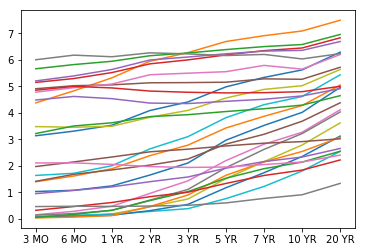

In [18]:
plt.plot(yieldcurvesdf);

A little difficult to decipher which is where, lets separate this into subplots. How about 7 plots with 4 lines each?

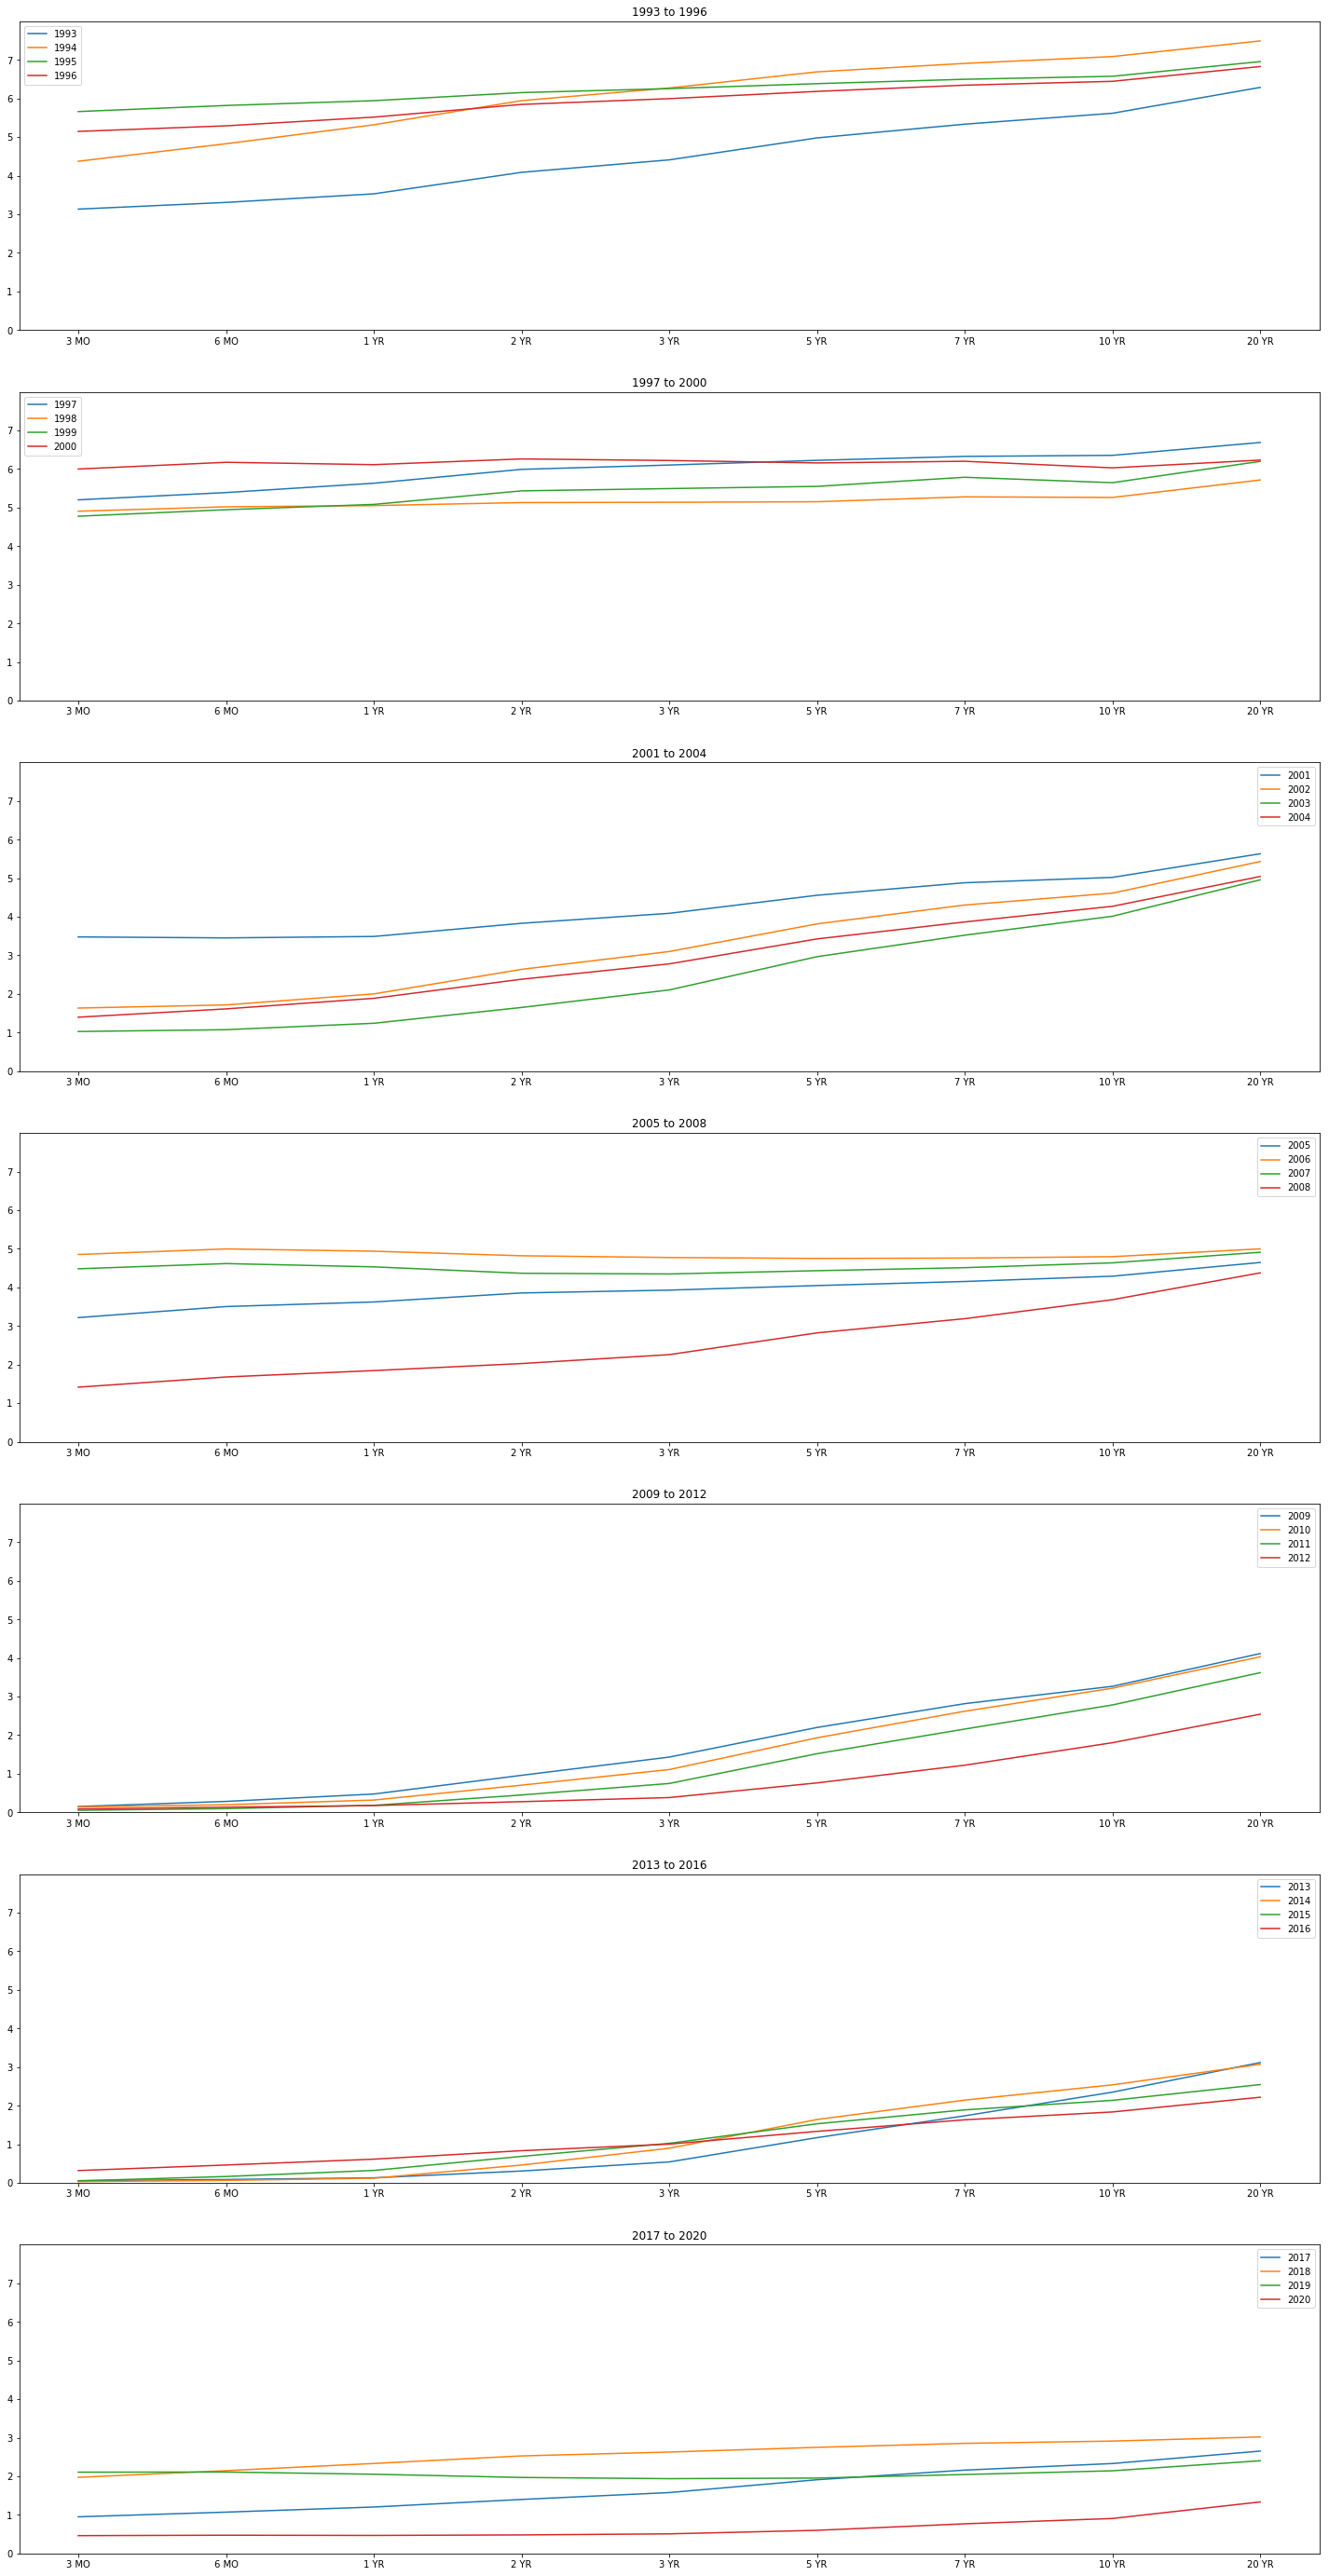

In [19]:
f, axes = plt.subplots(7, 1, figsize=(25, 50))
j = 0
while j < 7:
    for i in range(0,len(dfyear),4):
        new = yieldcurvesdf.iloc[:,i:i+4]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{new.columns[0]} to {new.columns[-1]}")
        axes[j].plot(new, label = new.columns)
        axes[j].legend(new)
        
        j += 1

This is a good generalization of the yield curve for each year, but lets add a `fill_between` of `yield ± 1σ` for each maturity at each given year 

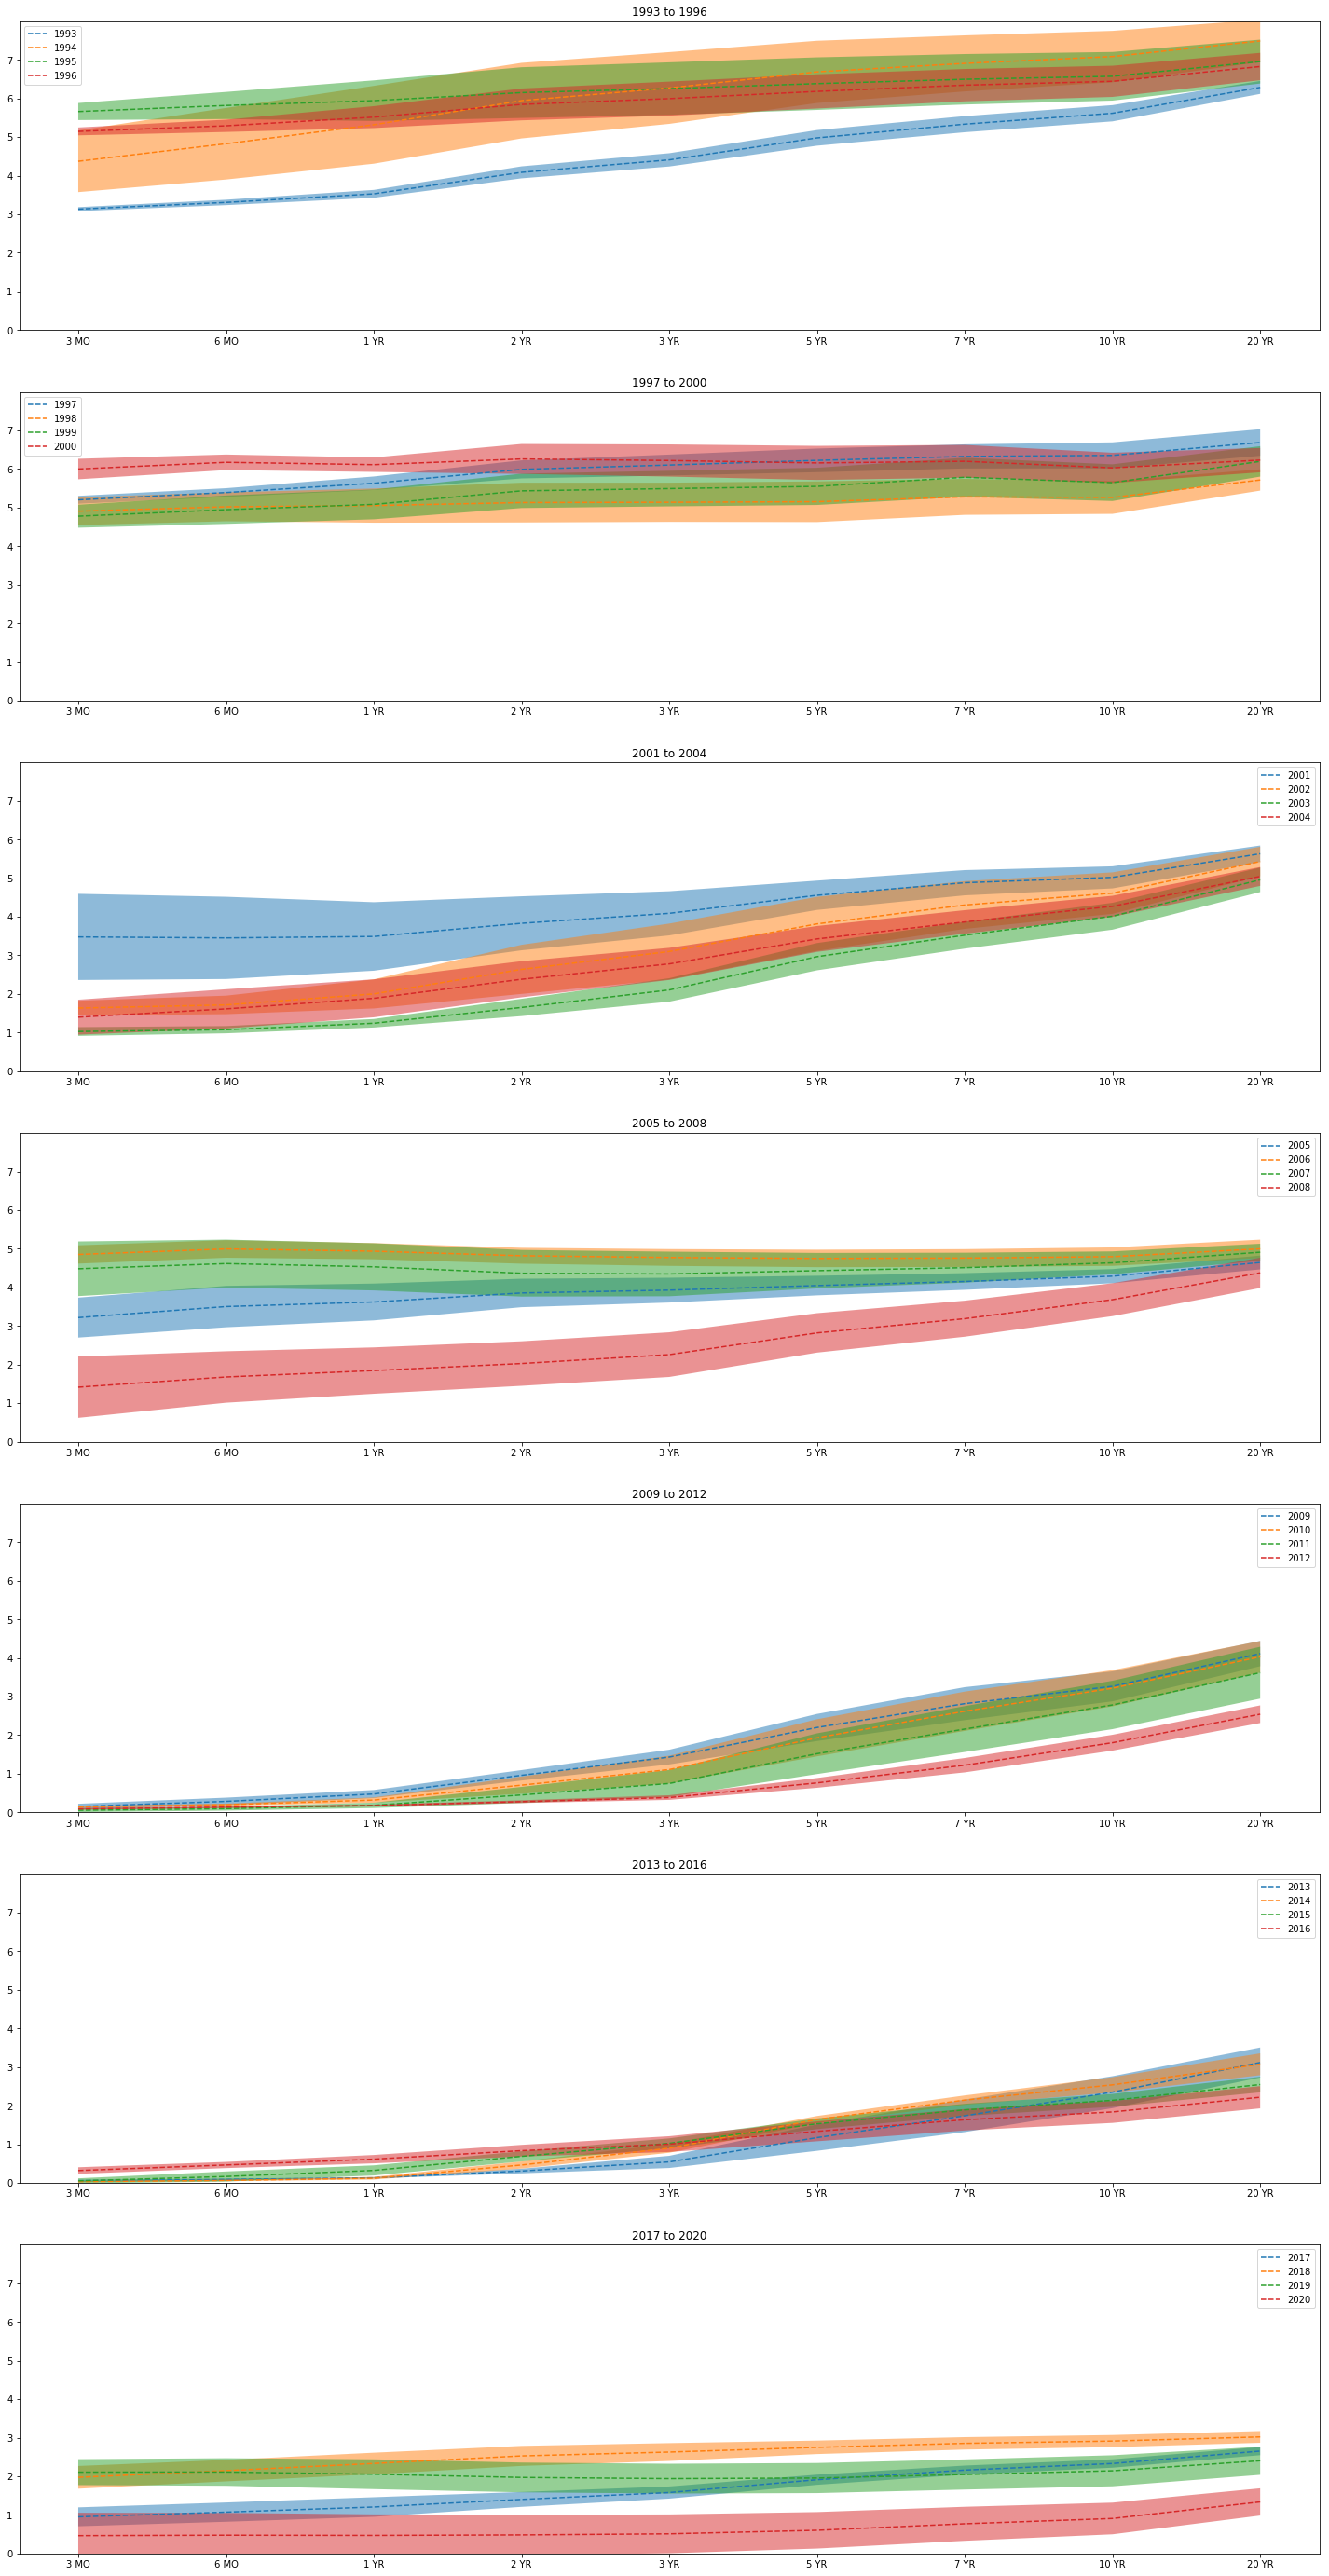

In [20]:
f, axes = plt.subplots(7, 1, figsize=(25, 50))
j = 0
while j < 7:
    for i in range(0,len(dfyear),4):
        temp = yieldcurvesdf.iloc[:,i:i+4]
        temp2 = yieldcurvestd.iloc[:,i:i+4]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{temp.columns[0]} to {temp.columns[-1]}")
        axes[j].plot(temp, linestyle = '--')
        for k in range(4):
            axes[j].fill_between(x = yieldcurvesdf.index, y1 = temp.values[:,k] + temp2.values[:,k], y2 = temp.values[:,k] - temp2.values[:,k],
                                alpha=0.5, label = '± σ')
        axes[j].legend(temp)
        
        j += 1

## Interpretation of The Yield Curve

This plot offers a lot of fundamental information about the macroeconomic climate. For example, one can observe multiple differences in

**Level** - A parallel increase or decrease in the interest rates.

**Steepness** - Long term interest rates increased while short term rates decreased. 

**Curvature** - Short term and long term increases while intermediate term has little change

Also, we have plotted a 
`average rate ± σ `for each individual year to observe the annual volatilty. For example, 2001 had high amounts of volatility in the short-term interest rate market. In comparison to 2011, where there is little volatility in the short and intermediate term interest rate market while spread in the long term market (10-20 years) exhbits some variance 

This is important for security holdings because interest rate volatility is the cause of price volatility. The assumed/ typical volatility structure is that short term rates are more volatile (greater standard deviation) than long-term rates. Although, the data data visualization clearly shows some exceptions.

There are several theories for the reasonance of yield curve shapes. There is **Unbiased Expectations Theory**, **Local Expectations Theory**, **Liquidity Preference Theory**, **Segmented Markets Theory** and **Preferred Habitat Theory**. I just graduated from my Economics BA, so I am pretty jaded when it comes to explaining theory, so the astute reader can feel free to Investopedia these things! 


# Splitting data & Normalizing Data

80% of the data will be trained, while 20% will be tested. Lets also note that we will do some hyper parameter tunning with our data as well so we will be using scikit's `TimeSeriesSplit`

Option 1

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
scaler.transform(df)

array([[ 0.27338868,  0.26830257,  0.32287476, ...,  0.68754238,
         0.78208721,  0.95945595],
       [ 0.29210462,  0.29583142,  0.32287476, ...,  0.69299845,
         0.78208721,  0.94745326],
       [ 0.31082056,  0.30959585,  0.33662842, ...,  0.69845453,
         0.78795396,  0.95945595],
       ...,
       [-1.07883794, -1.10814002, -1.15793533, ..., -1.80042812,
        -1.94595255, -1.98120219],
       [-1.07415895, -1.10355188, -1.15335078, ..., -1.79497204,
        -1.9400858 , -1.9691995 ],
       [-1.07415895, -1.10814002, -1.15793533, ..., -1.80588419,
        -1.9518193 , -1.98120219]])

Option 2 

In [22]:
mean = df.mean(axis = 0)
std = df.std(axis = 0)
df -= mean
df /= std

In [23]:
split = int(len(df) * 0.8)
df_train = df.iloc[:split]
df_test = df.iloc[split:]

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

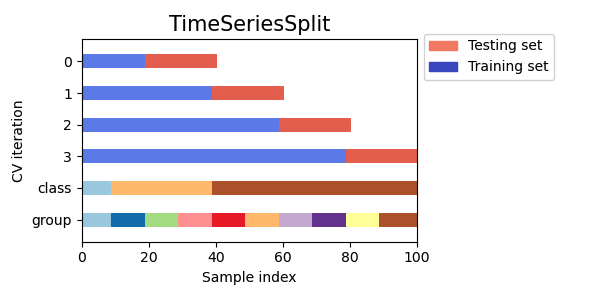

## Augmented Dickey-Fuller Test 
- To be continued:
- Test for stationairity

Stationarity at is simplest- Auto-covaraiance and time are independent. 

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [24]:
for i in range(len(df.columns)):
    adf, p, usedlag, nobs, cvs, bic = sm.tsa.stattools.adfuller(df.iloc[:,i], autolag = "BIC")
    print(f'{df.columns[i]}\n\t t-stat:{round(adf,2)}, p-val: {round(p,2)}\n\t Maximized IC: {round(bic,2)}')

3 MO
	 t-stat:-0.71, p-val: 0.84
	 Maximized IC: -32042.73
6 MO
	 t-stat:-0.81, p-val: 0.82
	 Maximized IC: -34626.95
1 YR
	 t-stat:-0.46, p-val: 0.9
	 Maximized IC: -33926.68
2 YR
	 t-stat:-0.66, p-val: 0.86
	 Maximized IC: -30652.2
3 YR
	 t-stat:-0.73, p-val: 0.84
	 Maximized IC: -29349.37
5 YR
	 t-stat:-0.82, p-val: 0.81
	 Maximized IC: -27534.85
7 YR
	 t-stat:-0.85, p-val: 0.8
	 Maximized IC: -26635.71
10 YR
	 t-stat:-0.82, p-val: 0.81
	 Maximized IC: -26309.55
20 YR
	 t-stat:-0.79, p-val: 0.82
	 Maximized IC: -26776.92


Conclusion: Non-stationarity

We will use an arbitrary number of lags for ease of implementation, I chose 30 for this example. This will produce a 3D tensor of (Number of Samples, Lags, Features) 

In Sequence learning, the time series variables are transformed into overlapping sequences.

Period 1: `[0,1,2,3,4,5,6,7,8,9] = Lags, [10,11,12,13,14,] = Time Steps`

Period 2: `[1,2,3,4,5,6,7,8,9,10] = Lags, [11,12,13,14,15] = Time Steps`

...

In [25]:
def lagfeatures(df, lags, steps):
    """
    df: pandas DataFrame
    lags: number of lags, i.e. sequence length
    steps: forecasting horizon
    
    return 
    lagarr- A matrix with the appropriate lags, and steps from a dataframe.
    """
    lag_list = []
    for lag in range(lags + steps - 1, steps - 1, -1):
        lag_list.append(df.shift(lag))
    
    lagarr = np.dstack([l[lags+steps-1:-1] for l in lag_list])
    
    # Right now, columns are insterted as rows. We need to flip the axes.
    return lagarr

In [27]:
def step_output(df, lags, steps):
    """
    Parameters
    ----------
    df: pandas DataFrame
    lags: number of lags, i.e. sequence length
    steps: forecasting horizon
    
    returns
    -------
    A 3D tensor actual y values for the next 5 days
    """
    step_list = []
    for step in range(steps,0, -1): #KNOW THIS
        step_list.append(df.shift(step))
    step_arr = np.dstack([l[lags+steps:] for l in step_list])

    return step_arr

In [28]:
lags = 200
steps = 5

Xtrain = lagfeatures(df_train, lags, steps)
Ytrain = step_output(df_train, lags, steps)
Xtest = lagfeatures(df_test, lags, steps)
Ytest = step_output(df_test, lags, steps)

print(f'{np.shape(Xtrain)} has a tensor dimension of 3 and it represents Obervations, Lags, and Features')
print(f'{np.shape(Ytrain)} has tensor dimension of 2 and it represents (Obervations and Timesteps)')
print(f'{np.shape(Xtest)} has a tensor dimension of 3 and it represents Obervations, Lags, and Features')
print(f'{np.shape(Ytest)} has tensor dimension of 2 and it represents (Obervations and Timesteps)')

(5191, 9, 200) has a tensor dimension of 3 and it represents Obervations, Lags, and Features
(5191, 9, 5) has tensor dimension of 2 and it represents (Obervations and Timesteps)
(1144, 9, 200) has a tensor dimension of 3 and it represents Obervations, Lags, and Features
(1144, 9, 5) has tensor dimension of 2 and it represents (Obervations and Timesteps)


In [29]:
df.head(10)

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993-10-01,0.273368,0.268283,0.322851,0.432034,0.514628,0.644834,0.687491,0.782029,0.959385
1993-10-04,0.292083,0.295809,0.322851,0.436639,0.505102,0.639686,0.692947,0.782029,0.947383
1993-10-05,0.310798,0.309573,0.336603,0.441244,0.514628,0.644834,0.698403,0.787896,0.959385
1993-10-06,0.301440,0.304985,0.327435,0.436639,0.505102,0.634538,0.698403,0.787896,0.959385
1993-10-07,0.306119,0.295809,0.322851,0.427429,0.500338,0.629391,0.698403,0.776163,0.953384
1993-10-08,0.306119,0.291222,0.313682,0.404404,0.471758,0.588207,0.649302,0.735099,0.899376
1993-10-12,0.338869,0.314161,0.327435,0.422824,0.481285,0.603651,0.654757,0.740965,0.899376
1993-10-13,0.329512,0.309573,0.327435,0.432034,0.481285,0.603651,0.660213,0.740965,0.905377
1993-10-14,0.320155,0.300397,0.327435,0.422824,0.471758,0.588207,0.632935,0.717500,0.875372


In [30]:
Xtrain[0,:,-1]

array([0.95644956, 1.09867481, 1.3084563 , 1.47738078, 1.59590501,
       1.76193206, 1.81135967, 1.91422846, 1.87152136])

### Construct a 'Naive' Baseline Prediction
Let's see if our model can beat a simple model prediction. 
How about predicting the next 5 days of the yield curve. At time index `t`, will predict the next `t+5` days. So we will use the values of `t` and repeat them to predict the next `t + 5` days. The shapes of both should be (5, 9) or `(Steps, Features)`


In [31]:
def naive_prediction_y(arr, steps):
    '''
    arr- Training Array
    steps - How many steps to predict
    
    Return: mae_pred, a (steps,feature) tensor  
    '''
    #Each mean absolute error for each prediction
    agg_maes = []
    ypred = []
    for i in range(1,len(Xtrain)+ 1):
        idx = i-1
        ypred.append([Xtrain[idx,:,-1]]* steps)
    return np.array(ypred)

In [32]:
def naive_prediction_mae(arr, steps):
    '''
    arr- Training Array
    steps - How many steps to predict
    
    Return: mae_pred, a (steps,feature) tensor  
    '''
    #Each mean absolute error for each prediction
    agg_maes = []
    for i in range(1,len(Xtrain)-steps + 1):
        idx = i-1
        ypred = np.array([Xtrain[idx ,:,-1]]* steps) #Shape of (5,9). Each row of the array will be the same.
        y = np.array([Xtrain[i:i + steps,:,-1],]) # Shape of (5, 9)
        mae =np.mean(np.abs(y - ypred), axis = 0)# Return mean of each column, now (1,9) 
        agg_maes.append(mae)
        mae_pred = np.mean(agg_maes, axis = 0)
    return mae_pred

In [33]:
y_naivepred= naive_prediction_y(Xtrain, 5)
y_naivepred.shape

(5191, 5, 9)

In [34]:
naive_error = naive_prediction_mae(Xtrain, 5)

In [35]:
np.set_printoptions(suppress=True,precision = 7) #Not in scientific notation

In [36]:
for i in range(len(naive_error)):
    print(f'{i+1} time step(s) ahead obtained an average error of \n {naive_error[i]}')

1 time step(s) ahead obtained an average error of 
 [0.012062  0.0108564 0.0126176 0.017851  0.0203649 0.0239449 0.025775
 0.0265251 0.0255345]
2 time step(s) ahead obtained an average error of 
 [0.0183059 0.0159998 0.0184146 0.0260115 0.0296243 0.0347737 0.0372829
 0.038303  0.0363572]
3 time step(s) ahead obtained an average error of 
 [0.0220733 0.019442  0.0225896 0.0315081 0.036097  0.0424043 0.0454811
 0.046745  0.0444525]
4 time step(s) ahead obtained an average error of 
 [0.0245913 0.0221419 0.0260653 0.0361957 0.0415685 0.0488953 0.0525253
 0.0542764 0.0514647]
5 time step(s) ahead obtained an average error of 
 [0.0273519 0.0246924 0.02932   0.0402174 0.0462032 0.0544005 0.0583776
 0.0603339 0.0573973]


In [37]:
feature_avg = np.mean(naive_error, axis = 1)
print(f'Mean Absolute Errorfor each feature: {[(term , mae) for term ,mae in zip(df.columns,feature_avg)]}')

Mean Absolute Errorfor each feature: [('3 MO', 0.01950350171353407), ('6 MO', 0.02834143894408242), ('1 YR', 0.034532541635908444), ('2 YR', 0.03974716210572397), ('3 YR', 0.04425492589253663)]


In [38]:
step_avg = np.mean(naive_error, axis = 0)
print(f'Mean Absolute Error for each feature: {[(steps + 1 , mae) for steps ,mae in zip(range(steps),step_avg)]}')

Mean Absolute Error for each feature: [(1, 0.020876865700780442), (2, 0.018626510862719495), (3, 0.02180143501016943), (4, 0.03035676305273735), (5, 0.034771593831606586)]


In [39]:
naive_pred = np.mean(naive_error)
naive_pred

0.03327591405835711

In [40]:
naive_pred

0.03327591405835711

Example, for the `3 month`, the naive prediction exhibits an MAE of approximately 7.2 basis points

In [41]:
model = tf.keras.models.Sequential()
model.add(LSTM(units = 64,return_sequences=True,input_shape=Xtrain.shape[-2:]))
model.add(Dropout(0.2))
model.add(LSTM(units = 64,activation ='sigmoid',return_sequences=True,input_shape=Xtrain.shape[-2:]))
model.add(Dense(5))
model.compile(optimizer=RMSprop(learning_rate = 0.001, momentum = 0.5),loss=tf.keras.losses.MeanAbsoluteError())
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 64)             67840     
_________________________________________________________________
dropout (Dropout)            (None, 9, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 64)             33024     
_________________________________________________________________
dense (Dense)                (None, 9, 5)              325       
Total params: 101,189
Trainable params: 101,189
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
epoch_ = 200
early_stopping = EarlyStopping(monitor='loss', patience = 40, restore_best_weights=True)
history = model.fit(Xtrain,Ytrain,epochs=epoch_, callbacks=[early_stopping],  validation_split=0.1, shuffle=False, verbose = 2)

Epoch 1/200
146/146 - 4s - loss: 0.2932 - val_loss: 0.1590
Epoch 2/200
146/146 - 3s - loss: 0.2252 - val_loss: 0.1028
Epoch 3/200
146/146 - 3s - loss: 0.1665 - val_loss: 0.1189
Epoch 4/200
146/146 - 3s - loss: 0.1517 - val_loss: 0.1323
Epoch 5/200
146/146 - 4s - loss: 0.1413 - val_loss: 0.1352
Epoch 6/200
146/146 - 4s - loss: 0.1346 - val_loss: 0.1123
Epoch 7/200
146/146 - 3s - loss: 0.1335 - val_loss: 0.1167
Epoch 8/200
146/146 - 3s - loss: 0.1284 - val_loss: 0.0981
Epoch 9/200
146/146 - 3s - loss: 0.1248 - val_loss: 0.1133
Epoch 10/200
146/146 - 2s - loss: 0.1232 - val_loss: 0.1424
Epoch 11/200
146/146 - 2s - loss: 0.1197 - val_loss: 0.1344
Epoch 12/200
146/146 - 2s - loss: 0.1175 - val_loss: 0.1380
Epoch 13/200
146/146 - 2s - loss: 0.1141 - val_loss: 0.1389
Epoch 14/200
146/146 - 2s - loss: 0.1088 - val_loss: 0.1321
Epoch 15/200
146/146 - 3s - loss: 0.1057 - val_loss: 0.1378
Epoch 16/200
146/146 - 3s - loss: 0.1087 - val_loss: 0.1306
Epoch 17/200
146/146 - 2s - loss: 0.1064 - val_lo

146/146 - 2s - loss: 0.0650 - val_loss: 0.0713
Epoch 138/200
146/146 - 3s - loss: 0.0677 - val_loss: 0.0625
Epoch 139/200
146/146 - 3s - loss: 0.0655 - val_loss: 0.0620
Epoch 140/200
146/146 - 3s - loss: 0.0678 - val_loss: 0.0737
Epoch 141/200
146/146 - 2s - loss: 0.0637 - val_loss: 0.0715
Epoch 142/200
146/146 - 3s - loss: 0.0660 - val_loss: 0.0784
Epoch 143/200
146/146 - 2s - loss: 0.0670 - val_loss: 0.0810
Epoch 144/200
146/146 - 2s - loss: 0.0653 - val_loss: 0.0632
Epoch 145/200
146/146 - 3s - loss: 0.0625 - val_loss: 0.0721
Epoch 146/200
146/146 - 2s - loss: 0.0618 - val_loss: 0.0761
Epoch 147/200
146/146 - 3s - loss: 0.0620 - val_loss: 0.0771
Epoch 148/200
146/146 - 2s - loss: 0.0623 - val_loss: 0.0751
Epoch 149/200
146/146 - 3s - loss: 0.0622 - val_loss: 0.0680
Epoch 150/200
146/146 - 3s - loss: 0.0651 - val_loss: 0.0676
Epoch 151/200
146/146 - 2s - loss: 0.0681 - val_loss: 0.0628
Epoch 152/200
146/146 - 3s - loss: 0.0661 - val_loss: 0.0665
Epoch 153/200
146/146 - 2s - loss: 0.0

Things to care about for NN models:

- *Selection of architecture* of the NN models, More specifically the hidden layers, number of input variables, number of neurons,selection of activation functions, and Starting values of the weights
- Type of training/validation methodology, optimization algorithms, the choice of learning rate (Think factor 10), momentum term, and the stopping rule.

This is an art more than a science. If somebody wants to tweak around with the model or has any criticisms, about it. 

### Training & Validation Loss

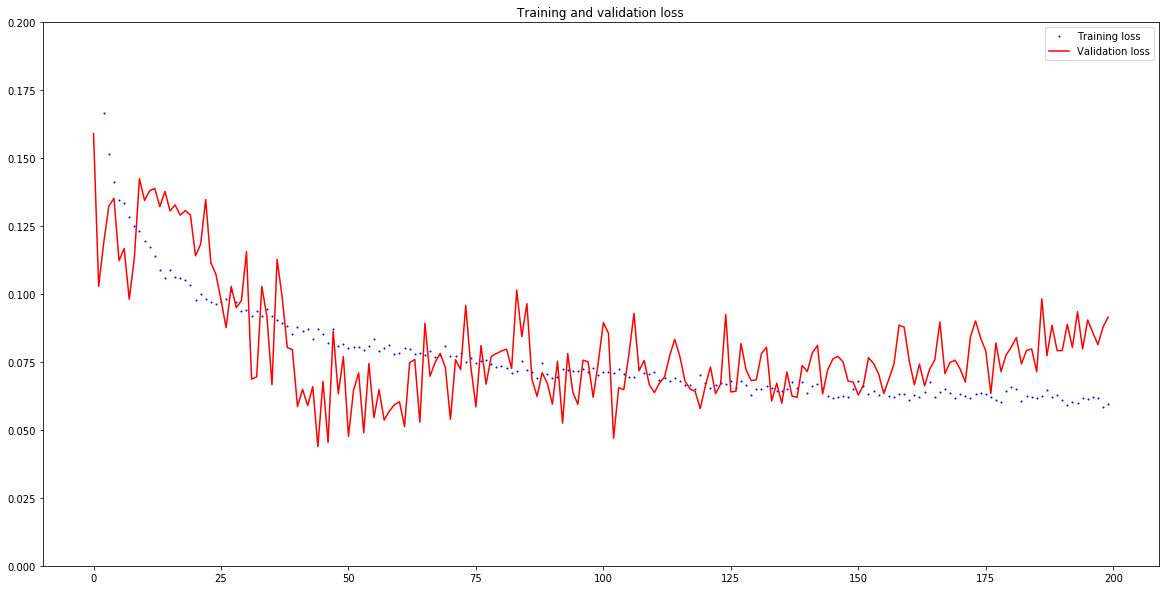

In [43]:
plt.figure(figsize=(20,10))
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_ = range(len(loss))
plt.hlines(y=naive_pred, colors='black', linestyles='--', xmin=0, xmax=epoch_)
plt.plot(epoch_, loss, 'bo', markersize = 1,label='Training loss')
plt.plot(epoch_, val_loss, 'b', label='Validation loss', color = 'red')
plt.title('Training and validation loss')
plt.ylim([0, 0.2])
plt.legend()

plt.show()

In [44]:
model_predict = model.predict(Xtrain)

In [45]:
y_naivepred = np.swapaxes(y_naivepred, 1, -1) #Before you execute this function, check out the shape. All we need to do is swap the last two axes.

In [46]:
y_ = np.array([])
pred_ = np.array([])
naive_ = np.array([])
for i in range(0,len(Ytrain),5): 
    y_ = np.concatenate((y_, Ytrain[i,0,:]))
    pred_ = np.concatenate((pred_, model_predict[i,0,:]))
    naive_ = np.concatenate((naive_, y_naivepred[i,0,:]))

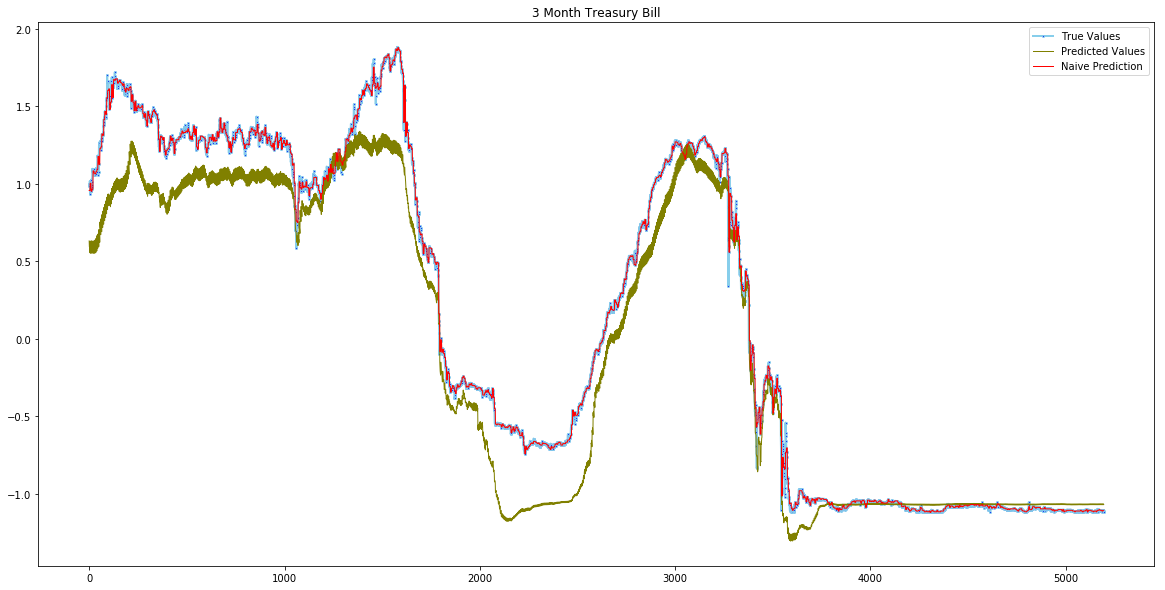

In [47]:
plt.figure(figsize=(20,10))
plt.plot(y_ ,marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=2, label = 'True Values')
plt.plot(pred_, marker='', color='olive', linewidth=1, label = 'Predicted Values')
plt.plot(naive_, color= 'red', linewidth=1, label = 'Naive Prediction')
plt.plot(x= df_train.index[lags + steps - 1:])
plt.title("3 Month Treasury Bill")
plt.legend();

The Naive Predictor performs sicnificantly better on the 3 month treasury-bill. Let's see its performance on the long-term treasury bill

### Plotting the 20 year
- I know I am duplicating code, which is bad practice. I hope to be able to make this into a function, but I have a couple other things going on, so it'll soon be updated!

In [48]:
y_ = np.array([])
pred_ = np.array([])
naive_ = np.array([])
for i in range(0,len(Ytrain),5): 
    y_ = np.concatenate((y_, Ytrain[i,-1,:]))
    pred_ = np.concatenate((pred_, model_predict[i,-1,:]))
    naive_ = np.concatenate((naive_, y_naivepred[i,-1,:]))

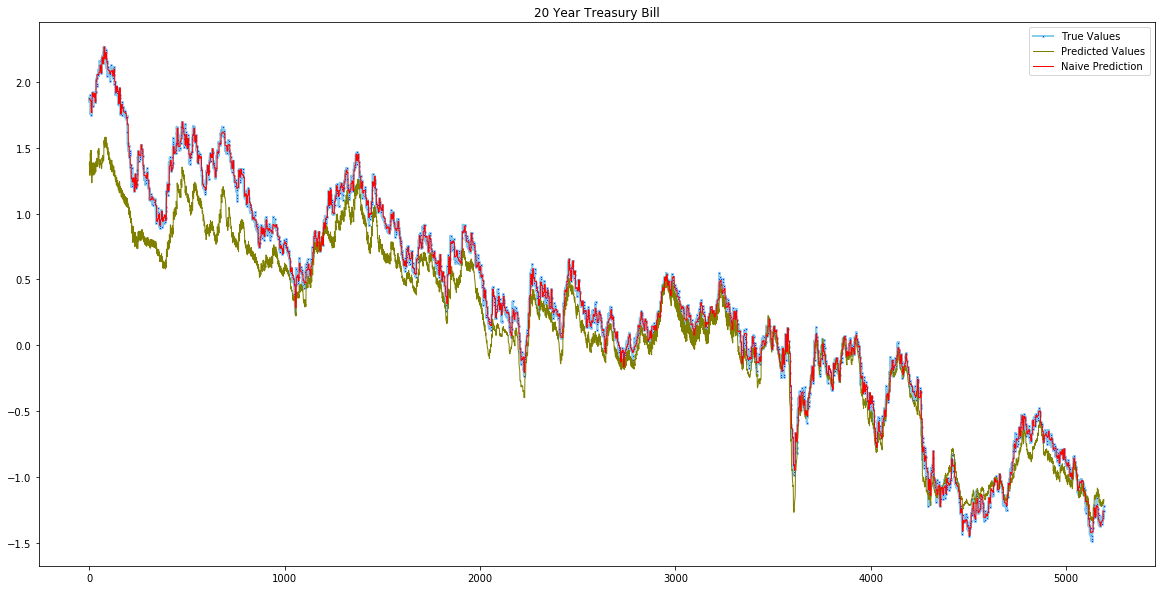

In [51]:
plt.figure(figsize=(20,10))
plt.plot(y_ ,marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=2, label = 'True Values')
plt.plot(pred_, marker='', color='olive', linewidth=1, label = 'Predicted Values')
plt.plot(naive_, color= 'red', linewidth=1, label = 'Naive Prediction')
plt.plot(x= df_train.index[lags + steps - 1:])
plt.title("20 Year Treasury Bill")
plt.legend();

The 20 year performs much better. Clearly, the reduced volatility in comparison to the 3 month improves its prediction performance.

### Improvement to still be made:

- Combining the naive mae and y prediction function into one to improve speed
- Creating a naive prediction plot function 